In [66]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from os.path import join as oj
import sys
sys.path.append('../vision_fit')
sys.path.append('../vision_analyze')
import data
import numpy as np
from copy import deepcopy
import pickle as pkl
from torch.optim.lr_scheduler import StepLR
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
import models
from dim_reduction import *
import viz_weights

%load_ext autoreload
%autoreload 2
%matplotlib inline

# load some models             
modelm = models.MnistNet()        
convnet = models.LeNet()
linnet = models.LinearNet(4, 28*28, 256, 10)
model = linnet
model = model.cuda()

# load mnist
from params_vision import p
p.dset = 'mnist'
p.shuffle_labels = False
train_loader, test_loader = data.get_data_loaders(p)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
# deal with reps
linnet = models.LinearNet(4, 28*28, 256, 10)
linnet = linnet.cuda()

# get the full dsets

In [68]:
X_train, Y_train, X_test, Y_test = data.process_loaders(train_loader, test_loader)
print(X_train.shape)

In [69]:
X_train, Y_train_onehot = data.get_XY(train_loader)
print(X_train.shape)

(60000, 784)


In [71]:
linnet(X_train[0]).data.cpu().detach().numpy()[0]

ValueError: Type must be a sub-type of ndarray type

In [70]:
# reset final weights to the activations of the final feature layer for 1 example per class
def reset_final_weights(p, s, it, model, X_train, Y_train_onehot):
    
    # get prototype images for each label (reps is how many repeats)
    # returns images (X) and labels (Y)
    def get_ims_per_lab(X_train, Y_train_onehot, reps=1):
        exs = np.zeros((10 * reps, X_train.shape[1]))
        labs = np.zeros(10 * reps)
        for i in range(10):
            idxs = Y_train_onehot[:, i] == 1
            exs[reps * i: reps * (i + 1)] = X_train[idxs][:reps]
            labs[reps * i: reps * (i + 1)] = i
        return exs, labs
    
    # pick the examples on the first iteration
    if it == 0:
        exs, _ = get_ims_per_lab(X_train, Y_train_onehot, p.reps)
        s.exs = exs

    # set the final layer of the dnn to the activations of the exs
    if it % p.reset_final_weights_freq == 0:
        if torch.cuda.is_available():
            exs = torch.Tensor(s.exs).cuda()
        else:
            exs = torch.Tensor(s.exs)
        # reshape for conv
        if p.use_conv:
            if 'mnist' in p.dset or p.dset in ['noise', 'bars']:
                exs = exs.reshape(exs.shape[0], 1, 28, 28)
            elif 'cifar10' in p.dset:
                exs = exs.reshape(exs.shape[0], 3, 32, 32)
            elif 'imagenet' in p.dset:
                print('imagenet not supported!')
        print('shapes', X_train.shape, exs.shape)
        acts = model.features(exs)
        last_lay = model.last_lay()
        acts = acts / acts.norm() * last_lay.weight.data.norm() # maintain norm
#         last_lay.weight = torch.nn.Parameter(acts)
        last_lay.weight.data = acts.data # torch.nn.Parameter(acts)

In [36]:
print(X_train.shape)

torch.Size([60000, 1, 28, 28])


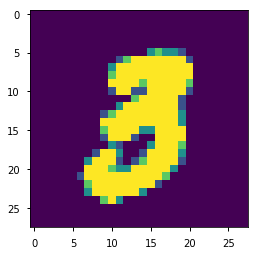

In [37]:
plt.imshow(X_train[1, 0].cpu().detach().numpy())
preds = linnet(X_train[0]).data.cpu().detach().numpy()[0]
# for i in range(10):
#     print(i, preds[i], end=' ')

In [53]:
linnet = models.LinearNet(num_layers=3, input_size=28*28, 
                          hidden_size=256, output_size=10, reps=2).cuda()
preds = linnet(X_train[0]).data.cpu().detach().numpy()[0]
print(preds.shape)
# linnet = models.LinearNet(4, 28*28, 256, 10)

(10,)


In [57]:
ex_nums = {}
i = 0
while(len(ex_nums) < 10):
    ex_nums[train_set.train_labels[i]] = i
    i += 1
exs = np.zeros((10, 28, 28))
for i in range(10):
    exs[i] = train_set.train_data[i]
train_set.train_data = torch.Tensor(exs)
train_set.train_labels = torch.Tensor(np.arange(0, 10)).long()

NameError: name 'train_set' is not defined

In [59]:
exs = torch.Tensor(100, 784)

In [65]:
exs.shape
exs.reshape(exs.shape[0], 1, 28, 28).shape

torch.Size([100, 1, 28, 28])

In [21]:
# get prototype images for each label (eventually support multiple reps)
# returns images (X) and labels (Y)
def get_ims_per_lab(X_train, Y_train_onehot, reps=2):
    exs = np.zeros((10, X_train.shape[1]))
    labs = np.zeros(10 * reps)
    for i in range(10):
        idxs = Y_train_onehot[:, i] == 1
        exs[reps * i: reps * (i + 1)] = X_train[idxs][:reps]
        labs[reps * i: reps * (i + 1)] = i
    return exs, labs
exs, labs = get_ims_per_lab(X_train, Y_train_onehot)



# print(exs.shape, labs)


# # reset final weights to the activations of the final feature layer for 1 example per class
# def reset_final_weights(p, s, it, model, X_train, Y_train_onehot):
#     # get prototype images for each label (eventually support multiple reps)
#     # returns images (X) and labels (Y)
#     def get_ims_per_lab(X_train, Y_train_onehot):
#         exs = np.zeros((10, X_train.shape[1]))
#         for i in range(10):
#             idxs = Y_train_onehot[:, i] == 1
#             exs[i] = X_train[idxs][0]
#         return exs, range(10)
    
#     # pick the examples on the first iteration
#     if it == 0:
#         exs, _ = get_ims_per_lab(X_train, Y_train_onehot)
#         s.exs = exs

#     # set the final layer of the dnn to the activations of the exs
#     if it % p.reset_final_weights_freq == 0:
#         if torch.cuda.is_available():
#             exs = torch.Tensor(s.exs).cuda()
#         else:
#             exs = torch.Tensor(s.exs)
#         acts = model.features(exs)
#         acts = acts / acts.norm() * model.fc[-1].weight.data.norm() # maintain norm
#         model.fc[-1].weight = torch.nn.Parameter(acts)

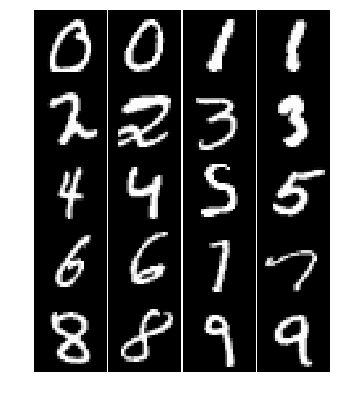

In [23]:
viz_weights.plot_weights(exs)

In [21]:
# set the final layer of the dnn to the activations of the exs
def set_final_lay_lin(linnet, exs):
    acts = linnet.features(exs)
    linnet.fc[-1].weight = torch.nn.Parameter(acts)
# exs = exs.cuda()
set_final_lay_lin(linnet, exs)    

RuntimeError: Expected object of backend CUDA but got backend CPU for argument #4 'mat1'

In [7]:
linnet.fc[-1].weight.data / linnet.fc[-1].weight.data.norm()

tensor([[ 0.0272,  0.0155,  0.0333,  ..., -0.0325, -0.0307,  0.0112],
        [ 0.0034,  0.0164,  0.0325,  ..., -0.0111,  0.0023, -0.0330],
        [-0.0275, -0.0006, -0.0244,  ..., -0.0065, -0.0244,  0.0091],
        ...,
        [-0.0104, -0.0284,  0.0312,  ...,  0.0291, -0.0067, -0.0221],
        [ 0.0111, -0.0296, -0.0103,  ...,  0.0265,  0.0235, -0.0072],
        [-0.0325, -0.0008,  0.0015,  ...,  0.0159,  0.0058,  0.0134]],
       device='cuda:0')